# سوال ۴
##  بخش ۳

در این قسمت نیز دقیقن همانند قسمت قبل بغات بصری را به دست می‌آوریم ولی در آخر برای دسته‌بندی هیستوگرام‌ها
از روش $SVM$ با کرنل $RBF$ استفاده می‌کنیم.

همچنین ماتریس کانفیوژن را تشکیل می‌دهیم که ردیف $i$ و ستون $j$ نشان دهنده این است که چه تعداد تشخیص داریم که دسته $i$ باشد ولی ما آن‌را $j$ تشخیص داده باشیم.

In [2]:
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
import os


def find_train_test_files(root_path, train_dir='Train', test_dir='Test'):
    category_names = []
    train_imgs = []
    train_labels = []
    test_imgs = []
    test_labels = []
    for root, dirs, files in os.walk(root_path):
        fs = root.replace(root_path, '').split(os.sep)
        if len(fs) != 2:
            continue
        category_name = fs[1]
        if category_name not in category_names:
            category_names.append(category_name)
        category_index = category_names.index(category_name)
        for f in files:
            img = cv.imread(os.path.join(root, f), cv.IMREAD_GRAYSCALE)
            if fs[0] == train_dir:
                train_imgs.append(img)
                train_labels.append(category_index)
            elif fs[0] == test_dir:
                test_imgs.append(img)
                test_labels.append(category_index)
    return train_imgs, np.array(train_labels), test_imgs, np.array(test_labels), category_names


root_path = './data/hw3/Data/'

train_imgs, train_labels, test_imgs, test_labels, category_names = find_train_test_files(root_path)

In [3]:
ft_cnt = 100
sift = cv.SIFT_create(ft_cnt)
train_imgs_words = np.vstack([sift.detectAndCompute(img, None)[1] for img in train_imgs])

clus_cnt = 80
train_imgs_dict = KMeans(clus_cnt)
train_imgs_dict.fit(train_imgs_words)


def extract_word_hist(imgs_list, word_dict):
    imgs_word_hist = []
    sift = cv.SIFT_create()
    for img in imgs_list:
        img_ft = sift.detectAndCompute(img, None)[1]
        img_words = word_dict.predict(img_ft).tolist()
        hist = np.array([img_words.count(i) for i in range(word_dict.n_clusters)])
        hist = hist / hist.sum()
        imgs_word_hist.append(hist)
    return np.array(imgs_word_hist)


train_imgs_hist = extract_word_hist(train_imgs, train_imgs_dict)
test_imgs_hist = extract_word_hist(test_imgs, train_imgs_dict)

مدل را با $SVM$ تست می‌کنیم:

In [4]:
accs = []
skf = StratifiedKFold()
for train_idx, valid_idx in skf.split(train_imgs_hist, train_labels):
    clf = SVC(C=1.2, kernel='rbf')
    clf.fit(train_imgs_hist[train_idx], train_labels[train_idx])
    accs.append(accuracy_score(train_labels[valid_idx], clf.predict(train_imgs_hist[valid_idx])))
print('train accuracy:', np.average(accs))

clf = SVC(C=1.2, kernel='rbf')
clf.fit(train_imgs_hist, train_labels)
print('test accuracy:', accuracy_score(test_labels, clf.predict(test_imgs_hist)))

train accuracy: 0.5530988274706867
test accuracy: 0.5233333333333333


در ادامه می‌توانید ماتریس کانفیوژن را ببینید:

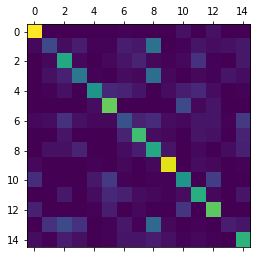

[[91  0  0  0  0  0  1  0  0  0  4  0  4  0  0]
 [ 2 20  3  7  1  1  7  6 34  0  1  5  3  4  6]
 [ 0  2 55  2  0  2  5  9  2  1  2 13  1  0  6]
 [ 0  4  8 36  1  0  3  2 33  2  0  2  1  5  3]
 [ 0  1  4  0 47 10  9  5  0  3  7 10  3  0  1]
 [ 0  0  0  0  3 70  0  0  0  0 20  2  5  0  0]
 [ 2  3 13  4  2  2 23  9 11  3  2  5  5  1 15]
 [ 0  0  5  0  0  0  9 63  3  2  0  5  4  0  9]
 [ 0  4  4  9  0  0  3  7 55  5  0  2  0  3  8]
 [ 2  0  0  0  1  0  2  0  2 87  0  3  2  0  1]
 [12  0  0  0  6 15  1  0  1  1 47  0 17  0  0]
 [ 0  0  6  0  3 10  8  3  2  1  3 57  2  0  5]
 [ 8  0  0  0  1  7  0  2  0  0 14  0 68  0  0]
 [ 0 13 20 13  0  1  6  1 31  2  0  1  0  7  5]
 [ 3  1  7  4  0  1  5  5  7  4  1  2  1  0 59]]


In [5]:
cnf_mat = confusion_matrix(test_labels, clf.predict(test_imgs_hist))
plt.matshow(cnf_mat)
plt.savefig('./out/res09.jpg')
plt.show()
print(cnf_mat)